In [1]:
import numpy as np
import pandas as pd
import pickle
#from zipfile import ZipFile
#import mne

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# ml libraries
#from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter
from collections import deque

#import optuna
#from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
np.set_printoptions(suppress=True)

# Model serialization
import pickle
import joblib

import serial
import time
#import json

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import read_omg_csv, add_diff, get_mse, get_limits, get_active_sensors, get_means, reset_random_seeds, callbacks 
from utils.figures import get_signals_plot,  get_signals_comparison_plot, plot_history  

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
#PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
#sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Read files

In [5]:
palm_file_3_1 = '../data/sprint3_pilote1_mount1_gestures.palm'

gestures_3_1 = read_omg_csv(palm_file_3_1, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_1.shape)
display(gestures_3_1.head(3))

# train_test_div_num = int(len(gestures_3_1)*0.8)
# gestures_train_3_1 = gestures_3_1.iloc[:train_test_div_num]
# gestures_test_3_1 = gestures_3_1.iloc[train_test_div_num:]
# print('train :', gestures_train_3_1.shape, 'test: ', gestures_test_3_1.shape)

(19569, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,6,0,7,0,0,12,0,13,20,0,...,57,6,22,27,19,0,0,0,34,980322
1,6,4,1,5,9,2,10,2,13,6,...,28,6,22,27,19,0,0,0,34,980355
2,9,0,4,15,2,8,22,9,10,14,...,7,6,22,27,19,0,0,0,34,980388


In [6]:
palm_file_3_2 = '../data/sprint3_pilote1_mount2_gestures.palm'
gestures_3_2 = read_omg_csv(palm_file_3_2, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_2.shape)
display(gestures_3_2.head(3))

# train_test_div_num = int(len(gestures_3_2)*0.8)
# gestures_train_3_2 = gestures_3_2.iloc[:train_test_div_num]
# gestures_test_3_2 = gestures_3_2.iloc[train_test_div_num:]
# print('train: ' ,gestures_train_3_2.shape, 'test: ', gestures_test_3_2.shape)

(19628, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,9,8,0,2,22,10,4,6,7,28,...,5,17,27,38,34,11,0,0,0,253431
1,4,11,0,16,0,9,1,5,16,0,...,3,17,27,38,34,11,0,0,0,253464
2,8,9,4,0,4,22,4,5,16,0,...,-1,17,27,38,34,11,0,0,0,253497


### Gestures train and test

In [7]:
# Обозначение колонок для удобства доступа
# [X features] '0', ..., '49' - каналы OMG датчиков
OMG_CH  = [str(i) for i in range(50)] #[str(i) for i in range(50)]
OMG_CHI = [x for x in range(50)]

# 'ACC0', 'ACC1', 'ACC2' - акселерометр 
ACC_CH = config.ACC_CH

# 'GYR0', 'GYR1', 'GYR2' - гироскоп
GYR_CH = config.GYR_CH

# [y target] = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5'] - координаты пальцев в перчатке GLOVE
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем

# 'BUTTON' - не используется
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

# Обозначение признаков разницы
col_diff_names = [str(x) + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времен

# assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_3_1.shape[-1]
# assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_3_2.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

#print(gestures_train.shape, gestures_test.shape, mounts['gestures_train_2'].shape, mounts['gestures_test_2'].shape)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

## Dataset concatenation

### Очищаем данные от выбросов

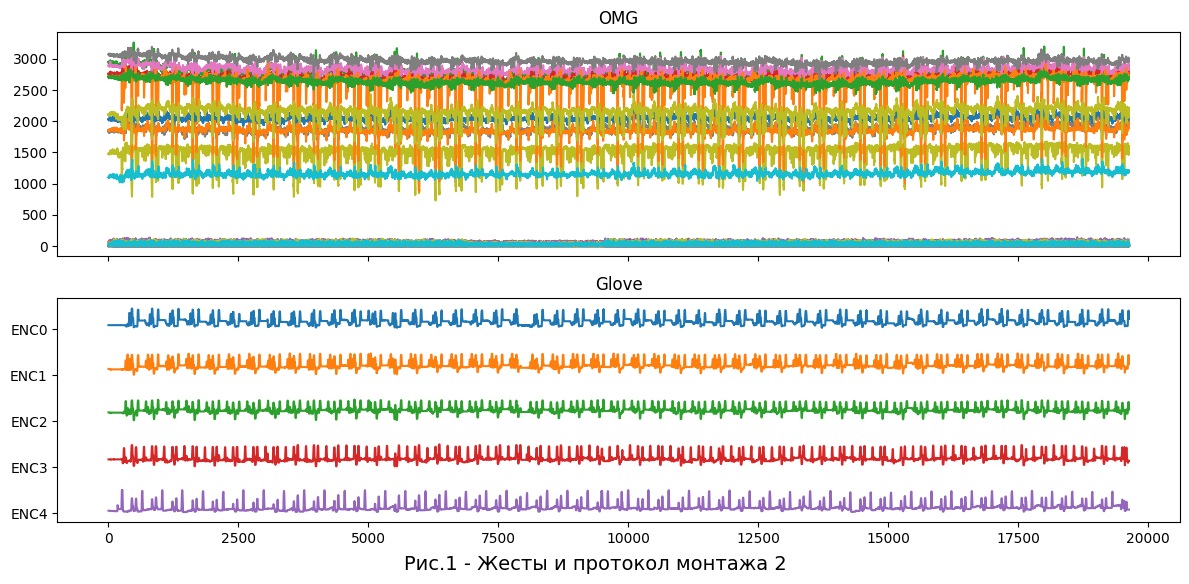

In [8]:
get_signals_plot(gestures_3_2[OMG_CH], gestures_3_2[GLOVE_CH].values, title='Рис.2 - Жесты и протокол монтажа 2', plot_counter=2) #Protocol gestures of the mount 2, plot_counter=1

In [ ]:
sensors2 = get_active_sensors(gestures_3_2[OMG_CH].values)
sensors = sensors1 = get_active_sensors(gestures_3_1[OMG_CH].values)

# Проверяем совпадение номеров активных сенсоров для обоих маунтов
assert sensors2 == sensors1

In [ ]:
# get sensor means and std
means2 = get_means(gestures_3_2[OMG_CH].values,sensors)
means1 = get_means(gestures_3_1[OMG_CH].values,sensors)

In [ ]:
# Определяем список коэффициентов для преобразования сигнала маунта 1 к уровню маунта 2
means_diff = {key: v[0] / means1[key][0] for key, v in means2.items()}

# convert to list
means_diff = list(means_diff.values())

In [ ]:
# Определяем диапазоны сигналов для обрезки
#iqrs=dict()
gestures_3_2_clipped, limits = get_limits(gestures_3_2.values)

# преобразования сигнала маунта 1 к уровню маунта 2  
temp = gestures_3_1.copy()
temp.iloc[:,sensors] = np.round(gestures_3_1.iloc[:,sensors] * means_diff)
gestures_3_1_clipped = get_limits(temp.values, limits)

In [ ]:
# # Смотрим на обрезанный сигнал (активных) датчиков 1 маунта

# idx = np.arange(gestures_3_1.shape[0])
# fig,ax = plt.subplots(1,1, figsize=(12,5))
# for i in sensors:
#     ax.plot(idx, gestures_3_1_clipped[:,i], label=f'sensor {i}') #color='k', 
#     #ax.plot(idx, gestures1[OMG_CH].iloc[:,12], color = 'r', label='transformed')
#     ax.yaxis.grid()
#     plt.legend(loc=(1.0,0.3));

In [ ]:
# Объединяем данные монтажей 2 и 1
#gestures = np.concatenate([gestures_3_2_clipped, gestures_3_1_clipped], axis=0) #.reset_index(drop=True)

# только монтаж 2
gestures = gestures_3_2_clipped

gestures = pd.DataFrame(gestures_3_2_clipped, columns=gestures_3_2.columns) 
gestures.shape

(19628, 65)

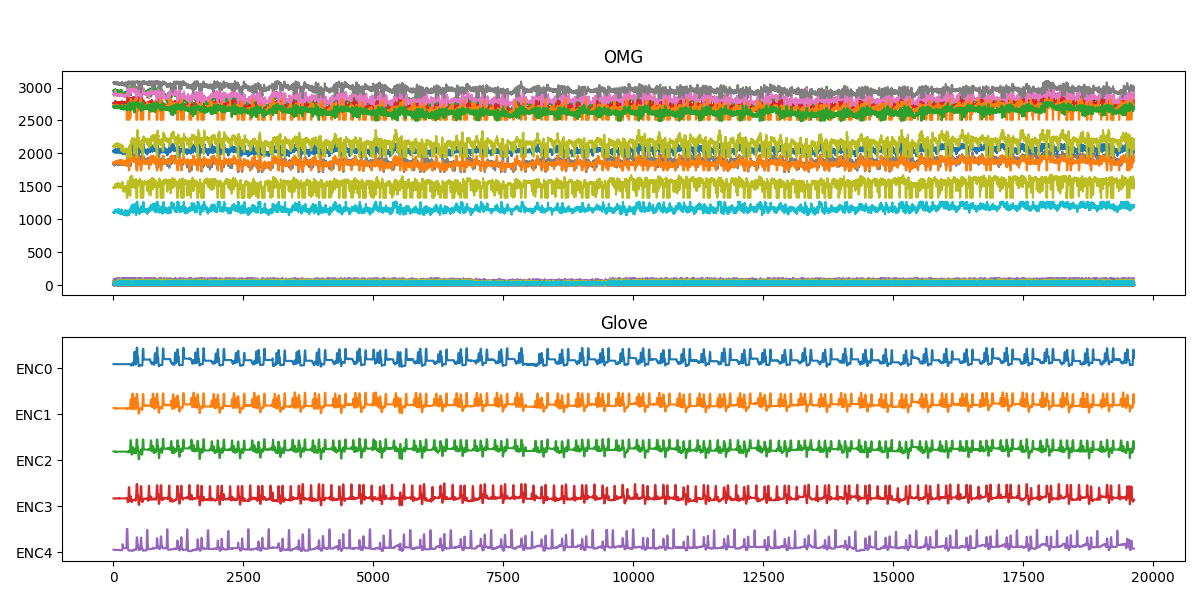

In [ ]:
get_signals_plot(gestures[OMG_CH], gestures[GLOVE_CH], title='Рис.1 - протокольные жесты монтажа 2', plot_counter=1) #Сравнение сигнала монтажей 2 и 1 ', plot_counter=1Protocol gestures of the mount 2

### Scaling the dataset

In [ ]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X, y = scaler.fit_transform(gestures[OMG_CH].values), gestures[GLOVE_CH].values/100 

joblib.dump(scaler, os.path.join(config.PATH_MODEL, "MinMax_scaler"+'.bin'), compress=True) 
print('X: ', X.shape, 'y: ', y.shape)

X:  (19628, 50) y:  (19628, 5)


In [ ]:
# Split data by 2 samples: train, test and valid
X_train, X_test, y_train, y_test= train_test_split(X, y, shuffle=False, test_size=0.2,  random_state=seed_value)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))

Train shape: (15702, 50)
Test shape:  (3926, 50)


In [ ]:
# Add differential values
X_train, X_test = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5) 

# Check samples shapes
print('Test add diff shape:  {}'.format(X_test.shape))

Test add diff shape:  (3926, 100)


# Modeling

### Модель с обучением по batch

In [ ]:
duration = 40
ts_events = np.arange(0, len(X_train), 15)

X_train_nn = [X_train[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])

print('Train :',X_train_nn.shape, y_train_nn.shape)

X_test_nn = [X_test[ts_event : ts_event + duration] for ts_event in ts_events]
y_test_nn = [y_test[ts_event : ts_event + duration] for ts_event in ts_events]

X_test_nn = np.array([arr for arr in X_test_nn if arr.shape == X_test_nn[0].shape])
y_test_nn = np.array([arr for arr in y_test_nn if arr.shape == y_test_nn[0].shape])

print('Test :', X_test_nn.shape, y_test_nn.shape)


Train : (1045, 40, 100) (1045, 40, 5)
Test : (260, 40, 100) (260, 40, 5)


In [ ]:
reset_random_seeds(seed_value)

n_timesteps = None
n_channels = X_train_nn.shape[-1] 
output_units = y_train_nn.shape[-1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.LSTM(units=100, 
                         #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                         return_sequences=True,
                         )(x) 
x = tf.keras.layers.Dropout(0.5)(x) #0.3

#output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ))(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001) #learning_rate=0.001
)

#callbacks_list = callbacks(1e-03, 'LSTM-60-5') #

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 5)          505       
 tributed)                                                       
                                                                 
Total params: 80,905
Trainable params: 80,905
Non-trainable params: 0
_________________________________________________________________


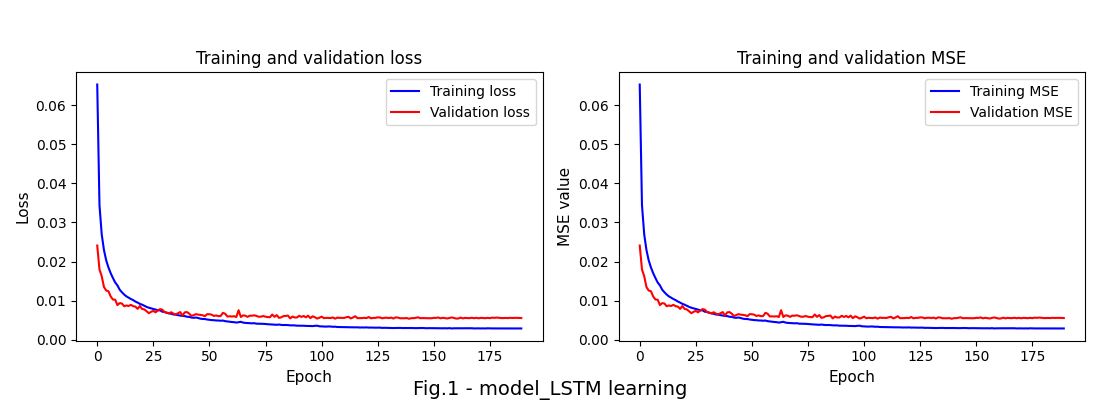

In [ ]:
history = model.fit(
    X_train_nn,
    y_train_nn, 
    epochs=500,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks(1e-04, model.name)
)

clear_output(False)

# plot_model(model)
plot_history(history, model_name=model.name, plot_counter=5)

### Prediction

1/1 [==============================] - 1s 938ms/step


,Train,Test
ENC0,12.2,99.3
ENC1,11.3,83.4
ENC2,9.6,69.7
ENC3,12.8,93.8
ENC4,16.7,83.3


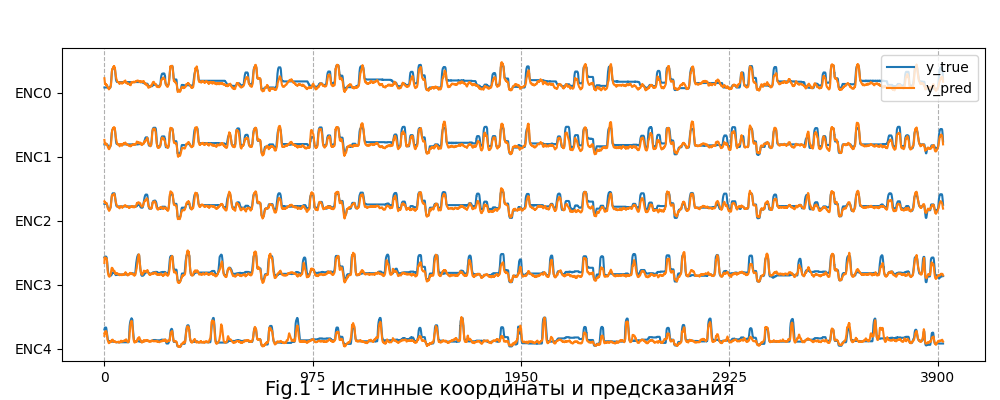

In [ ]:
# Loanding saved model
model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM.hdf5'))

y_pred_test = np.round(model.predict(X_test[None, :])[0]*100) 
y_pred_train = np.round(model.predict(X_train[None, :])[0]*100)
 
get_mse(y_test*100, y_pred_test, y_train*100, y_pred_train)

# Display comparison plot
get_signals_comparison_plot(y_test*100, y_pred_test)# y_train*100, y_pred_train

## Model_stateful

In [ ]:
# model  for inference
hidden_size = 100
n_timesteps = None

n_channels = X_train_nn.shape[-1]
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")


model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))

x = model_input #tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
    # return_state=True,
    # last state for each sample at index i in a batch will be used 
    # as initial state for the sample of index i in the following batch
    stateful=True,
    # speed-up a RNN, but more memory-intensive.
    # only suitable for short sequences.
    unroll=True
)(x)

x = tf.keras.layers.Dropout(0.5)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

# без компилирования не сработает
# model_stateful.save(os.path.join(config.PATH_MODEL, 'stateful.hdf5'))

# # # Загрузка модели из памяти
# model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM.hdf5'))



model_stateful.set_weights(model.get_weights())

model_stateful.summary()

input_shape = (None, 100) | output_units = 5
Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 1, 100)]             0         
                                                                 
 lstm (LSTM)                 (1, 1, 100)               80400     
                                                                 
 dropout (Dropout)           (1, 1, 100)               0         
                                                                 
 time_distributed (TimeDistr  (1, 1, 5)                505       
 ibuted)                                                         
                                                                 
Total params: 80,905
Trainable params: 80,905
Non-trainable params: 0
_________________________________________________________________


#### Предикт для датасета

In [ ]:
low_lim = 16500
hig_lim = 19500
#gestures_3_2 = pd.DataFrame(gestures_3_2, columns=gestures_3_1.columns)
check_data = gestures_3_2.loc[low_lim:,OMG_CH].values.astype(np.int16).copy() #
predicts = list()

# Скалируем
scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))
check_data_scaled = scaler.transform(check_data).astype(np.float16)

# добавляем дифф
check_data_diff  = add_diff(check_data_scaled, shift_=5)

for i in range(check_data_scaled.shape[0]):
    x = np.expand_dims(np.expand_dims(check_data_diff[i,:], 0), 0).astype(np.float16)
    #y_pred = (model_stateful.predict(x)[0][0]).astype(np.float16) - считает медленно
    y_pred = model_stateful(x.reshape(1,1,-1)).numpy()[0][0]
    predicts.append(np.round(y_pred, 2))

y_pred_stateful = np.vstack(predicts)
clear_output(wait=False)

# Для примера выводим 2 первых предсказания
#y_pred_stateful[:2,:]

,Test
ENC0,113.300003
ENC1,95.699997
ENC2,79.599998
ENC3,100.500000
ENC4,89.300003


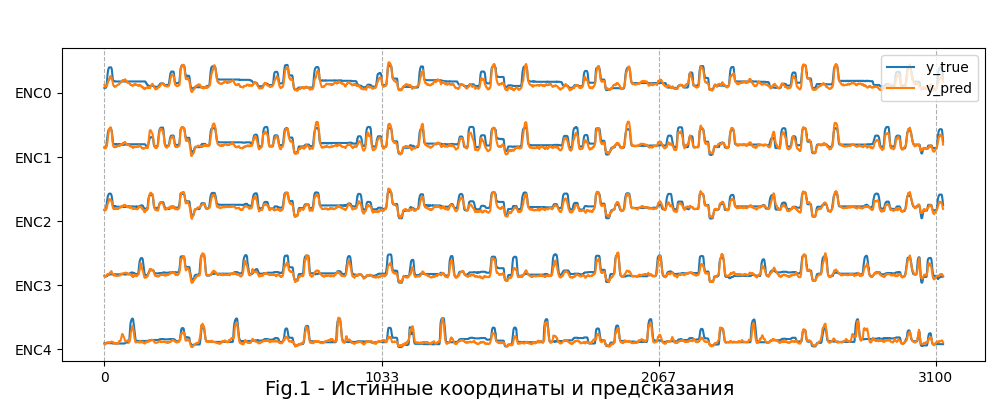

In [ ]:
# Display metrics
temp = gestures_3_2.loc[low_lim:, GLOVE_CH].values.astype(np.int16).copy()
get_mse(temp, y_pred_stateful*100)

# Display comparison plot
get_signals_comparison_plot(temp, y_pred_stateful*100) 

In [ ]:
# %%time

# model_stateful.reset_states()

# y_pred_stateful = []

# time_start = time.time()

# for i in range(check_data.shape[1]):
#     embedding_stateful = model_stateful(check_data[:, [i]], training=False)
#     y_pred_stateful.append(embedding_stateful.numpy())
    
# time_end = time.time()
# ts = (time_end - time_start) / len_check_data
    
# y_pred_stateful = np.hstack(y_pred_stateful)

# print(f"Avg time of {len_check_data} iters: {ts:.4f}")
# print(y_pred_stateful.shape)
# # y_pred_stateful[:, :10]

## Postprocessing

,Test
ENC0,115.900002
ENC1,98.400002
ENC2,81.900002
ENC3,103.099998
ENC4,90.199997


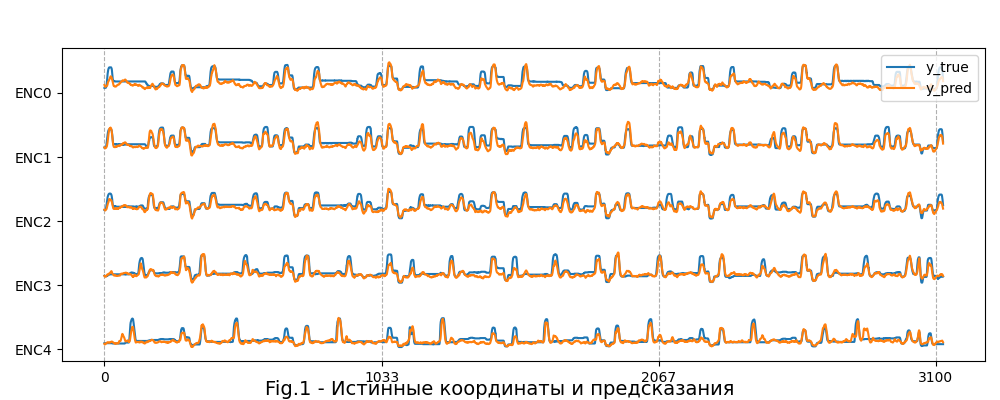

In [ ]:
preproc_coef = 0.57
prev = None

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

y_pred = y_pred_stateful
# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred)
y_pred_test_proc[0] = y_pred[0]


for i in range(1, len(y_pred)):
    y_pred_test_proc[i] = postprocessing(y_pred[i], y_pred[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100), 2) 

# Display metrics
temp = gestures_3_2.loc[low_lim:, GLOVE_CH].values.astype(np.int16).copy()
get_mse(temp, y_pred_test_proc*100)

# Display comparison plot
get_signals_comparison_plot(temp, y_pred_test_proc*100)

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [ ]:
# Scaling
scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))

# Empty buffer for data
buff = np.zeros((6,50))

def preprocessing2(x:np.array, buff:np.array=buff):
    
    buff[0], buff[1], buff[2], buff[3], buff[4] = buff[1], buff[2], buff[3], buff[4], buff[5]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[5] = x_scaled
    
    # Можно выбрать длину диффа
    y = np.hstack([x_scaled, buff[5]- buff[1]])
    
    #buff = np.transpose([savgol_filter(buff[:,i], window_length=6, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff 

In [ ]:
#x = y.copy()

# # ----- model stateful--------
saved_model = model_stateful


def inference(x:np.array, saved_model=saved_model)->np.array: 
    """Get inference using saved model

    Args:
        x (np.array): input vector
        saved_model (...): ml model

    Returns:
        (np.array): preiction
    """
    
    y_pred = saved_model(x.reshape(1,1,-1)).numpy()[0][0]*100
    return y_pred


In [ ]:
# set empty buffer
buff_pred = np.zeros((2,5))

def postprocessing(x:np.array, prev:np.array=None, preproc_coef:float=0.57)->np.array:
    """postprocessing of prediction

    Args:
        x (np.array): _description_. Defaults to predict.
        buff_pred (np.array): prediction buffer
        preproc_coef (float, optional): _description_. Defaults to 0.57.

    Returns:
        np.array: _description_
    """    
    if prev is None:
        y = x
       
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1

    return y

In [ ]:
dq = deque(maxlen=3)
def commands3(arr:np.array, postproc_threshold:int=2)->np.array:
    """Gets 'nogo' condition from all sensors

    Args:
        arr (np.array): _description_

    Returns:
        np.array: _description_
    """   
    # вычисляем разницу с между предыдущим показанием
    nogo = np.abs(np.subtract(arr[-1], arr[0]))

    # возвращаем координату, если разница превышает 2
    arr.append(np.round(np.where(nogo>postproc_threshold, arr[-1], arr[-2])))
    
    return np.clip(arr[-1], 0, 100)

## Inference

### Offline (dataset)
Проверка выполняется на монтаже 2. На части (X_train) датасета уже обучилась наша модель. Возьмём 20% датасета (X_test), которую модель не "видела".

In [ ]:
# Монтаж 2
gestures_new = read_omg_csv(palm_file_3_2, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

In [ ]:
def great_preprocessing(df:pd.DataFrame, sensors:list=sensors):
    sensors_new = get_active_sensors(df[OMG_CH].values)
    cols = df.columns
    # Проверяем совпадение номеров активных сенсоров для обоих маунтов
    assert sensors_new  == sensors

    # get sensor means and std
    means_new = get_means(df[OMG_CH].values, sensors)

    # Определяем список коэффициентов для преобразования сигнала маунта 1 к уровню маунта 2
    means_diff = {key: v[0] / means_new[key][0] for key, v in means2.items()}

    # convert to list
    means_diff = list(means_diff.values())

    # преобразования сигнала маунта 1 к уровню маунта 2  
    df.iloc[:,sensors] = (df.iloc[:,sensors] * means_diff)#.round()
    
    gestures_new_clipped = get_limits(df.values, limits)
    return pd.DataFrame(gestures_new_clipped, columns=cols)

In [ ]:
gestures_new_clipped = great_preprocessing(gestures_new)
df_sim = gestures_new_clipped.loc[15000:, :].astype(np.int16)

TIMEOUT =  0.033
DEBUG = True

model_stateful.reset_states()

i = 0
preproc_coef = 0.57
buff = np.zeros((6,50))

buff_pred = np.ones((3,5))*np.array([50,50,50,50,50])
ts_diff = 0 

dq = deque(buff_pred, maxlen=3)

y_previous = np.array([.32,.35,.45,.30,.10])

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands3':[],
    'ts_time':[],
}

saved_model = model_stateful
 
ts_old = time.time()

# Check input data format and shape
try:
    assert (type(df_sim), df_sim.shape) == (pd.DataFrame, (100,65))
except AssertionError as e1:
    print('Type(df_sim) must be pd.DataFrame, shape (100,65)')

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing2(omg_sample)
    
    # [Inference for   LSTM]
    y_predicted         = inference(sample_preprocessed)
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)  
    
    dq.append(y_postprocessed)

    # [Commands composition]
    y_commands3          = commands3(dq) #, postproc_threshold=2
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands3'].append(y_commands3)    # сглаженные команды
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start 
    y_dct['ts_time'].append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 
#print(f'Время вычисления: {np.mean(ts_list).round(3)} мс')

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: -16382


In [ ]:
# Display metrics
temp = np.array(y_dct['enc_sample'])
get_mse(temp, np.array(y_dct['y_commands3']))

,Test
ENC0,88.9
ENC1,83.0
ENC2,79.4
ENC3,101.0
ENC4,98.5


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (4628, 50)
enc_sample.shape = (4628, 6)
sample_preprocessed.shape = (4628, 100)
y_predicted.shape = (4628, 5)
y_postprocessed.shape = (4628, 5)
y_commands3.shape = (4628, 5)
ts_time.shape = (4628,)


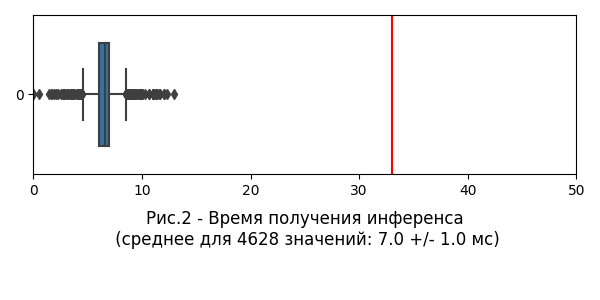

In [ ]:
# Загрузка сохраненного списка времен
times =  np.array([y_dct['ts_time']])*1000

fig, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(data=times, orient='h', width=0.65)
ax.set_xlim(0,50)
ax.axvline(33, color='r')
ax.set_title('Рис.5 - Время получения инференса\n (среднее для {} значений: {} +/- {} мс)'\
    .format(times.shape[1],np.round(np.mean(times)), np.round(np.std(times))), y=-0.50)
plt.tight_layout() #w_pad=0.8

plt.savefig(os.path.join(config.PATH_FIGURES,"fig_5.png"))

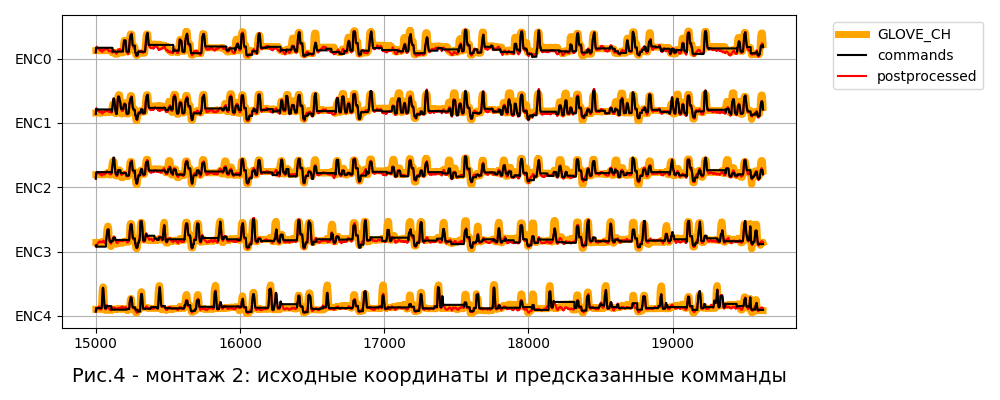

In [ ]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH', linewidth=5)
#ax.plot(xticks,   y_dct['y_predicted'] + dist, c='purple', label ='predicted')
ax.plot(xticks,   y_dct['y_postprocessed'] + dist, c='red', label ='postprocessed')
ax.plot(xticks,   y_dct['y_commands3'] + dist, c='k', label ='commands')

plt.title('Рис.6 - монтаж 2: исходные координаты и предсказанные комманды', y=-0.2, fontsize=14) #Ground truth vs predicted vs postprocessed vs commands
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

plot_counter = 3
plt.savefig(config.PATH_FIGURES + f'fig_{plot_counter}.png')

#### Проверка на монтаже 1

In [ ]:
gestures_new = read_omg_csv(palm_file_3_1, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

gestures_new_clipped = great_preprocessing(gestures_new)

In [ ]:
df_sim = gestures_new_clipped.loc[15000:, :].astype(np.int16).copy() 
print(df_sim.shape)

TIMEOUT =  0.033
DEBUG = True

model_stateful.reset_states()

i = 0
preproc_coef = 0.57
buff = np.zeros((6,50))

buff_pred = np.ones((3,5))*np.array([50,50,50,50,50])
ts_diff = 0 

dq = deque(buff_pred, maxlen=3)

y_previous = np.array([.32,.35,.45,.30,.10])

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands3':[],
    'ts_time':[],
}

saved_model = model_stateful
 
ts_old = time.time()

# Check input data format and shape
try:
    assert (type(df_sim), df_sim.shape) == (pd.DataFrame, (100,65))
except AssertionError as e1:
    print('Type(df_sim) must be pd.DataFrame, shape (100,65)')

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing2(omg_sample)
    
    # [Inference for   LSTM]
    y_predicted         = inference(sample_preprocessed)
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)  
    
    dq.append(y_postprocessed)

    # [Commands composition]
    y_commands3          = commands3(dq) #, postproc_threshold=2
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands3'].append(y_commands3)    # сглаженные команды
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start 
    y_dct['ts_time'].append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1  
#print(f'Время вычисления: {np.mean(ts_list).round(3)} мс')

# Display metrics
temp = np.array(y_dct['enc_sample'])[:,:5]
get_mse(temp, np.array(y_dct['y_commands3']))

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: -12334


,Test
ENC0,477.8
ENC1,508.4
ENC2,337.0
ENC3,375.8
ENC4,603.3


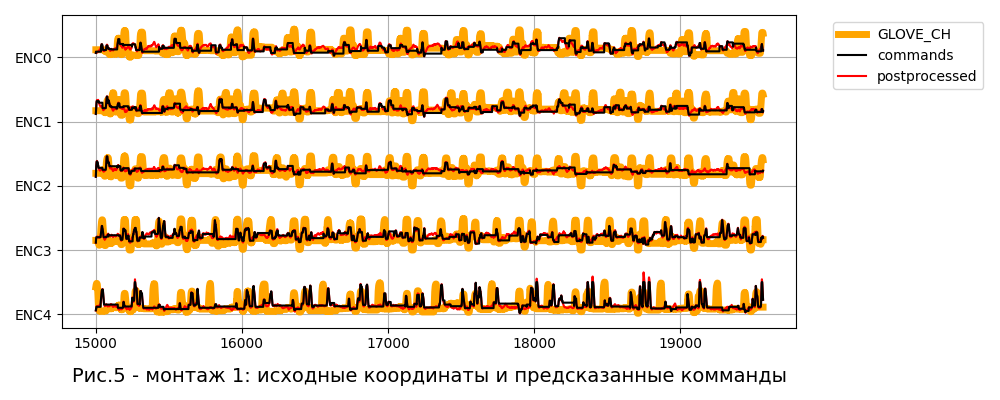

In [ ]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH', linewidth=5)
#ax.plot(xticks,   y_dct['y_predicted'] + dist, c='purple', label ='predicted')
ax.plot(xticks,   y_dct['y_postprocessed'] + dist, c='red', label ='postprocessed')
ax.plot(xticks,   y_dct['y_commands3'] + dist, c='k', label ='commands')

plt.title('Рис.7 - монтаж 1: исходные координаты и предсказанные комманды', y=-0.2, fontsize=14)
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

plot_counter = 4
plt.savefig(config.PATH_FIGURES + f'fig_{plot_counter}.png')

### Online (prosthesis or virtual hand)

In [ ]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# # ser_port = None
# ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 